In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ProjetoFinal2") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

In [ ]:
# Carregar o arquivo CSV em um DataFrame
df = spark.read.option("header", "true").csv("/content/Air_Traffic_Passenger_Statistics.csv")

In [ ]:
import pandas as pd

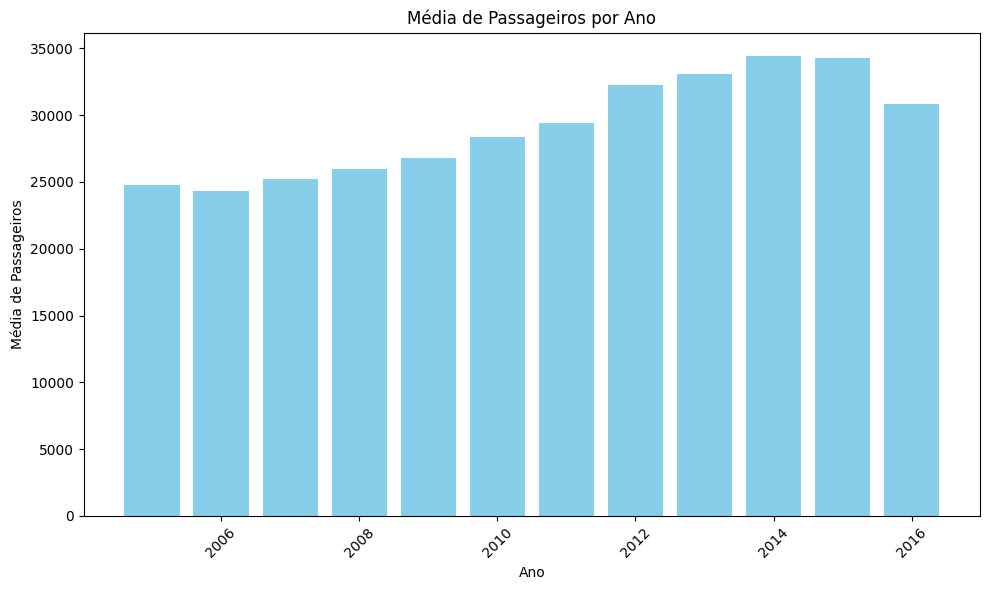

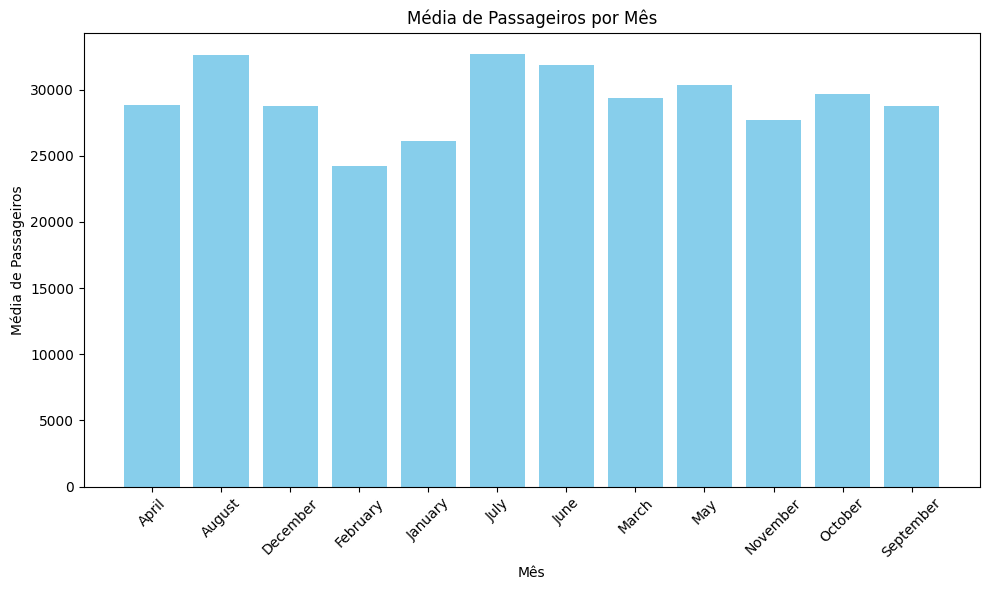

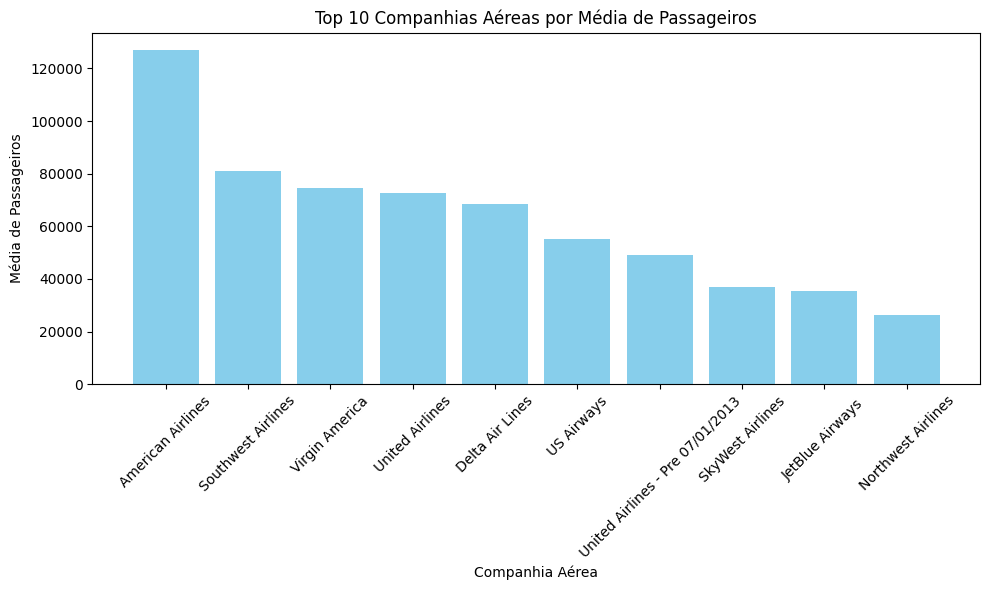

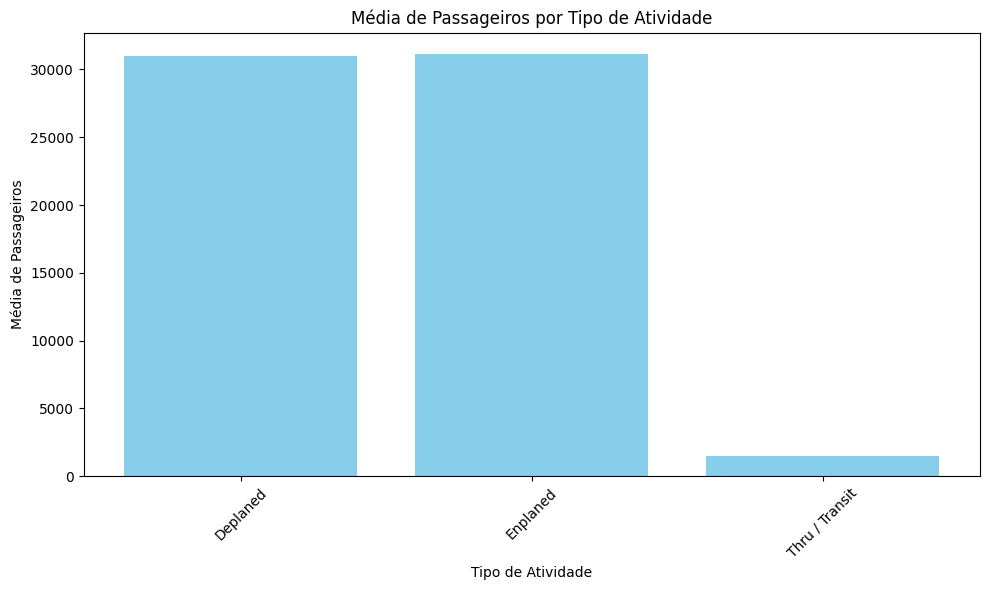

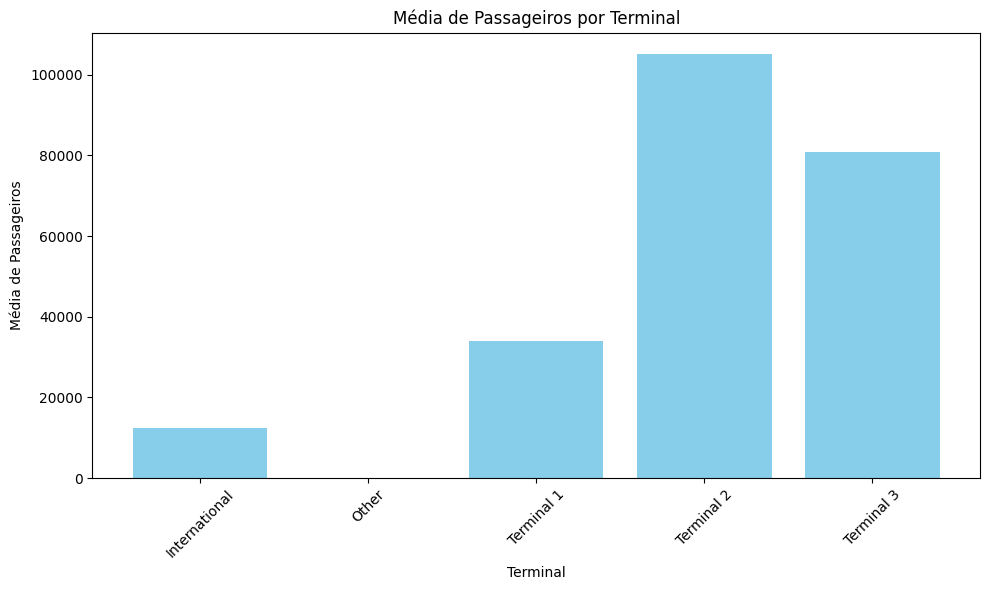

In [ ]:
# Para usar Pandas e gerar gráficos, convertemos o DataFrame PySpark para Pandas
df_pandas = df.toPandas()

# Importar matplotlib
import matplotlib.pyplot as plt

# Função para gerar gráficos de barras e também retornar os dados numericamente
def plot_bar_chart_with_data(dataframe, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(dataframe[x_col], dataframe[y_col], color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return dataframe[[x_col, y_col]]

# Converter as colunas numéricas corretamente (garantir que a conversão de texto para número está correta)
df_pandas['Passenger Count'] = pd.to_numeric(df_pandas['Passenger Count'], errors='coerce')
df_pandas['Year'] = pd.to_numeric(df_pandas['Year'], errors='coerce')

# 1. Número de passageiros por ano
group_by_year = df_pandas.groupby('Year')['Passenger Count'].agg(['mean']).reset_index()
numerical_data_year = plot_bar_chart_with_data(group_by_year, 'Year', 'mean', 'Média de Passageiros por Ano', 'Ano', 'Média de Passageiros')

# 2. Número de passageiros por mês
group_by_month = df_pandas.groupby('Month')['Passenger Count'].agg(['mean']).reset_index()
numerical_data_month = plot_bar_chart_with_data(group_by_month, 'Month', 'mean', 'Média de Passageiros por Mês', 'Mês', 'Média de Passageiros')

# 3. Número de passageiros por companhia aérea (Top 10)
group_by_airline = df_pandas.groupby('Operating Airline')['Passenger Count'].agg(['mean']).reset_index()
top_10_airlines = group_by_airline.sort_values(by='mean', ascending=False).head(10)
numerical_data_airlines = plot_bar_chart_with_data(top_10_airlines, 'Operating Airline', 'mean', 'Top 10 Companhias Aéreas por Média de Passageiros', 'Companhia Aérea', 'Média de Passageiros')

# 4. Número de passageiros por tipo de atividade
group_by_activity = df_pandas.groupby('Activity Type Code')['Passenger Count'].agg(['mean']).reset_index()
numerical_data_activity = plot_bar_chart_with_data(group_by_activity, 'Activity Type Code', 'mean', 'Média de Passageiros por Tipo de Atividade', 'Tipo de Atividade', 'Média de Passageiros')

# 5. Número de passageiros por terminal
group_by_terminal = df_pandas.groupby('Terminal')['Passenger Count'].agg(['mean']).reset_index()
numerical_data_terminal = plot_bar_chart_with_data(group_by_terminal, 'Terminal', 'mean', 'Média de Passageiros por Terminal', 'Terminal', 'Média de Passageiros')


In [ ]:
df = spark.read.option("header", "true").csv("/content/Air_Traffic_Passenger_Statistics.csv")

In [ ]:
from pyspark.ml.feature import StringIndexer

# Verificar o esquema do DataFrame
df.printSchema()

# Codificar colunas categóricas que podem ser relevantes para a correlação
categorical_cols = [
    'Operating Airline', 'Published Airline', 'GEO Summary', 'GEO Region',
    'Activity Type Code', 'Price Category Code', 'Terminal', 'Boarding Area',
    'Adjusted Activity Type Code', 'Month'
]

# Para cada coluna categórica, aplicar o StringIndexer
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_Indexed")
    df = indexer.fit(df).transform(df)

# Exibir algumas linhas para verificar as mudanças
df.show(5)

root
 |-- Activity Period: string (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- Published Airline: string (nullable = true)
 |-- Published Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Activity Type Code: string (nullable = true)
 |-- Price Category Code: string (nullable = true)
 |-- Terminal: string (nullable = true)
 |-- Boarding Area: string (nullable = true)
 |-- Passenger Count: string (nullable = true)
 |-- Adjusted Activity Type Code: string (nullable = true)
 |-- Adjusted Passenger Count: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+-----------

In [ ]:
# Após codificar, posso calcular a matriz de correlação apenas para colunas numéricas
# Selecionar colunas numéricas para a correlação
numeric_cols = ['Passenger Count', 'Adjusted Passenger Count', 'Year'] + [col + "_Indexed" for col in categorical_cols]

# Criar uma nova tabela apenas com as colunas numéricas
df_numeric = df.select(numeric_cols)

# Converter para Pandas para calcular a correlação (ou usar um método alternativo no PySpark)
df_numeric_pandas = df_numeric.toPandas()

# Calcular a matriz de correlação
correlation_matrix = df_numeric_pandas.corr()

# Exibir a matriz de correlação
print(correlation_matrix)

                                     Passenger Count  \
Passenger Count                             1.000000   
Adjusted Passenger Count                    0.999941   
Year                                        0.060069   
Operating Airline_Indexed                  -0.285452   
Published Airline_Indexed                  -0.273216   
GEO Summary_Indexed                         0.395743   
GEO Region_Indexed                         -0.299917   
Activity Type Code_Indexed                 -0.071423   
Price Category Code_Indexed                 0.065047   
Terminal_Indexed                            0.433388   
Boarding Area_Indexed                       0.344823   
Adjusted Activity Type Code_Indexed        -0.071423   
Month_Indexed                              -0.010581   

                                     Adjusted Passenger Count      Year  \
Passenger Count                                      0.999941  0.060069   
Adjusted Passenger Count                             1.000000  0.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Selecionar as colunas numéricas e as colunas codificadas para a regressão
numeric_cols = ['Passenger Count', 'Adjusted Passenger Count', 'Year'] + [col + "_Indexed" for col in categorical_cols]

# Criar um DataFrame com apenas colunas numéricas
df_numeric = df.select(numeric_cols)

# Converter o DataFrame PySpark para pandas
df_pandas = df_numeric.toPandas()

# Definir as variáveis independentes (X) e dependente (y)
X = df_pandas[['Adjusted Passenger Count', 'Terminal_Indexed', 'Boarding Area_Indexed',
               'GEO Summary_Indexed', 'Operating Airline_Indexed', 'Published Airline_Indexed',
               'Price Category Code_Indexed', 'GEO Region_Indexed']]
y = df_pandas['Passenger Count']

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo de Regressão Linear
model = LinearRegression()

# Ajustar o modelo aos dados de treino
model.fit(X_train, y_train)

# Prever os valores no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Exibir os resultados da avaliação
print(f'Erro Quadrático Médio (MSE): {mse}')
print(f'R²: {r2}')


Erro Quadrático Médio (MSE): 460026.29476472054
R²: 0.9998585471008191


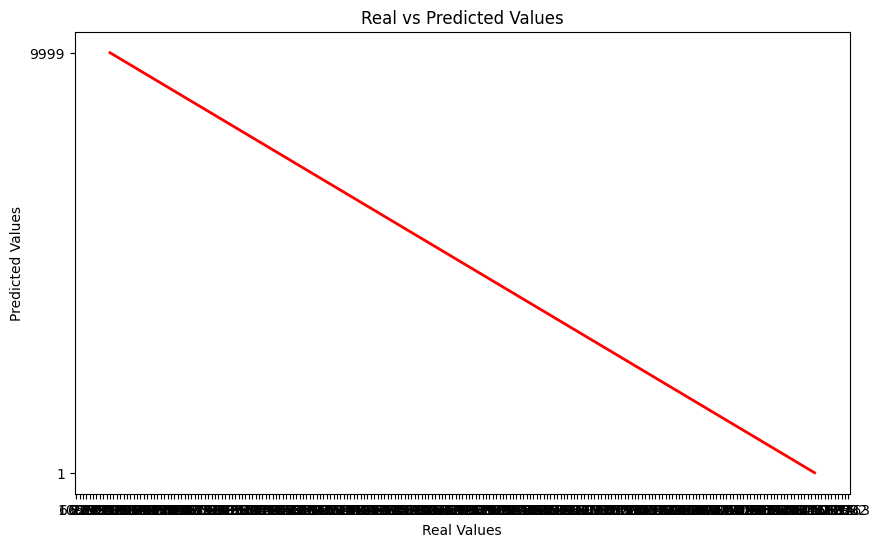

In [ ]:
import matplotlib.pyplot as plt

# Criar o gráfico Real vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Linha de referência
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values')
plt.show()
